# Loading Libraries and Data

In [1]:
import jalali
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None 

df = pd.read_csv('Data//Daily.csv', names = ['persian_date','value'], header=None)
df['date'] = df.apply(lambda row: jalali.Persian(row['persian_date']).gregorian_string("{}/{}/{}"), axis=1)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head(5)

,persian_date,value
date,,
2011-11-22,1390/09/01,3.990182e+08
2011-11-23,1390/09/02,3.979580e+08
2011-11-24,1390/09/03,3.976629e+08
2011-11-25,1390/09/04,3.974873e+08
2011-11-26,1390/09/05,3.956593e+08


# Plotting the Values

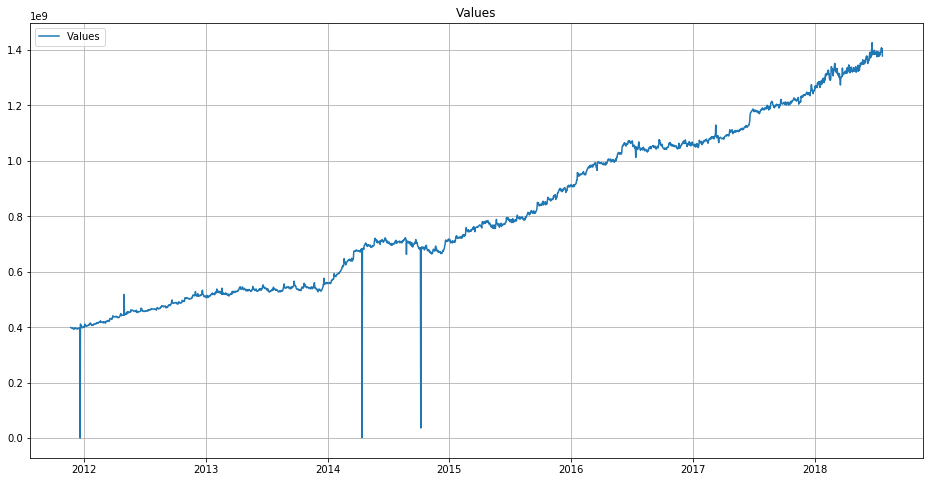

In [2]:
plt.figure(figsize=(16,8))
plt.title('Values')

plt.plot(df['value'], label='Values')

plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Autocorrelation Function (ACF)

- $x$ is input values
- $\bar{x}$ is average of input values 
- $n$ is the length of input values
- $k$ is the lag 

\begin{align}
\large
ACF_k = \frac{ \displaystyle\sum\limits_{i=1}^{n-k}(x_i - \bar{x})(x_{i+k} - \bar{x}) } {\displaystyle\sum\limits_{i=1}^{n}(x_i - \bar{x})^2} = \frac{A} {B}
\end{align}

In [3]:
def acf(series, k):

    xi, xik, A, B = 0., 0., 0., 0. 
    xbar = series.mean()
    n = len(series)

    for i in range(1, n + 1):
        xi = series[i - 1]
        B += (xi - xbar) * (xi - xbar)
        if (i <= n - k):
            xik = series[i + k - 1]
            A += (xi - xbar) * (xik - xbar) 
       
    return A / B

# Calculating ACF for different lags in range [2,365]

In [4]:
acfs = pd.DataFrame(columns = ['lag','value'], dtype = float)

for lag in range(0, int(len(df))):
    acfs.loc[lag] = {'lag': lag, 'value': acf(df['value'], lag)}
    
acfs.set_index('lag', inplace = True)

print(acfs[acfs['value'] < 0.2].iloc[0])

value    0.19969
Name: 700.0, dtype: float64


# Plotting Correlograms

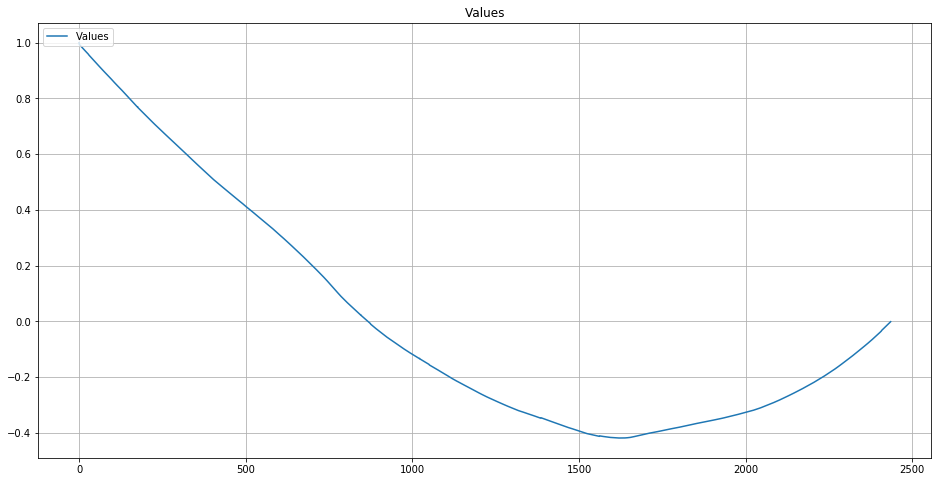

In [5]:
plt.figure(figsize=(16,8))
plt.title('Values')

plt.plot(acfs['value'], label='Values')

plt.legend(loc='upper left')
plt.grid(True)
plt.show() 

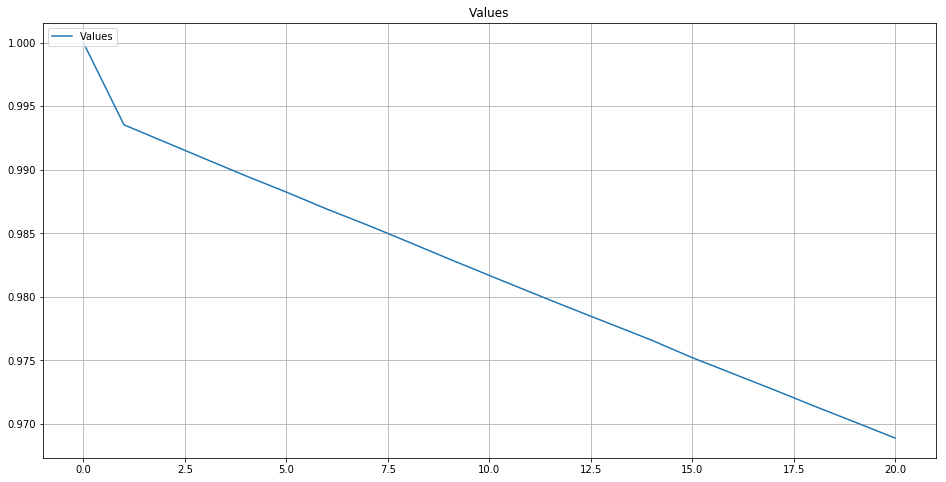

In [6]:
plt.figure(figsize=(16,8))
plt.title('Values')

plt.plot(acfs[:20]['value'], label='Values')

plt.legend(loc='upper left')
plt.grid(True)
plt.show() 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


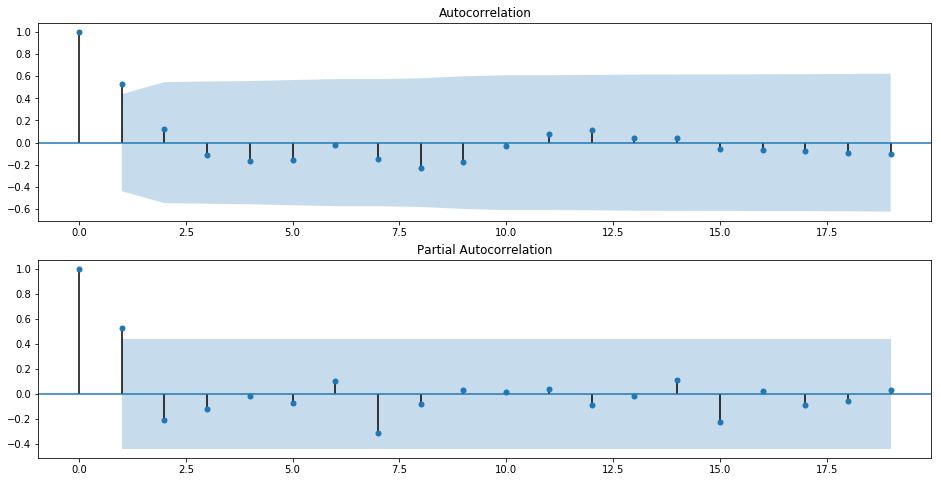

In [7]:
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

plt.figure(figsize=(16,8))
plt.title('ACF and PACF')

pyplot.subplot(211)
plot_acf(df[:20]['value'], ax = pyplot.gca())
pyplot.subplot(212)
plot_pacf(df[:20]['value'], ax = pyplot.gca())
pyplot.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


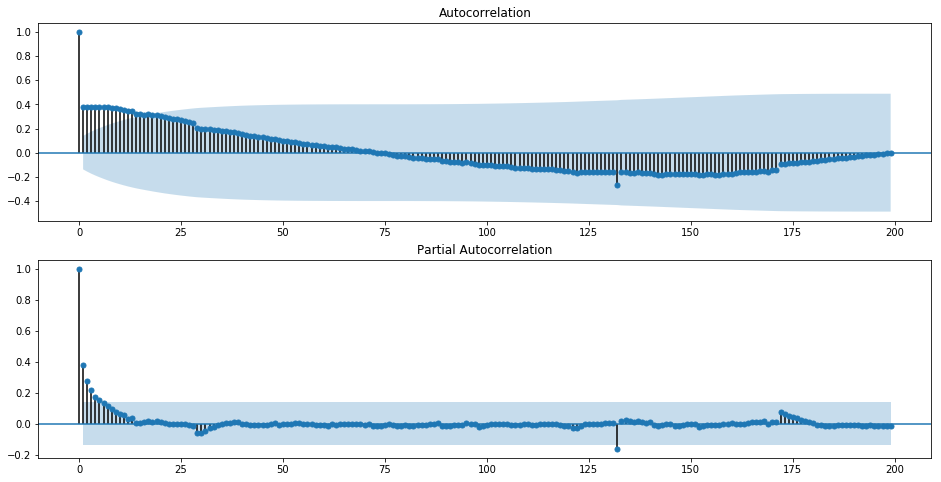

In [6]:
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

plt.figure(figsize=(16,8))
plt.title('ACF and PACF')

pyplot.subplot(211)
plot_acf(df[:200]['value'], ax = pyplot.gca())
pyplot.subplot(212)
plot_pacf(df[:200]['value'], ax = pyplot.gca())
pyplot.show()

# Detecting Outliers 

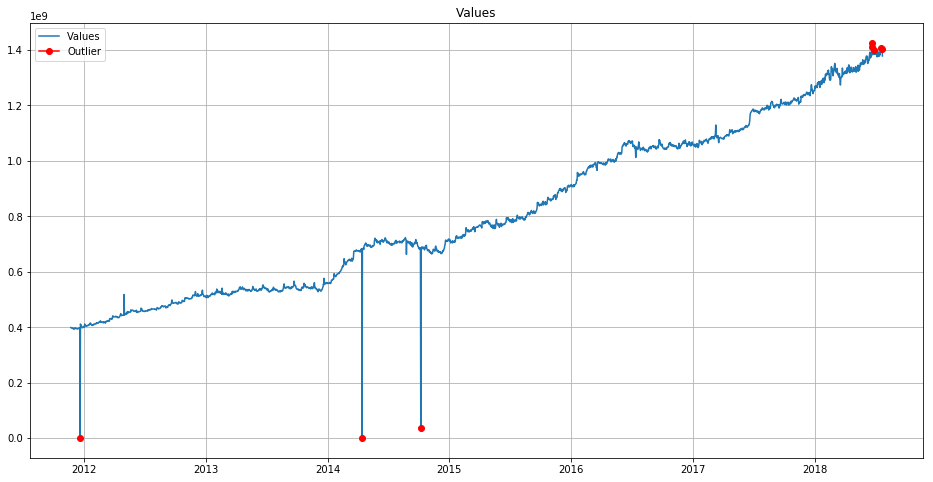

           persian_date         value       outlier
date                                               
2011-12-20   1390/09/29  3.209963e+05  3.209963e+05
2014-04-14   1393/01/25  1.650354e+06  1.650354e+06
2014-10-07   1393/07/15  3.656233e+07  3.656233e+07
2018-06-21   1397/03/31  1.410546e+09  1.410546e+09
2018-06-22   1397/04/01  1.426280e+09  1.426280e+09
2018-06-29   1397/04/08  1.399084e+09  1.399084e+09
2018-07-20   1397/04/29  1.407787e+09  1.407787e+09
2018-07-22   1397/04/31  1.405175e+09  1.405175e+09


In [7]:
min_o = df['value'].mean() - 2 * df['value'].std()
max_o = df['value'].mean() + 2 * df['value'].std()
df['outlier'] = df[(df['value'] <  min_o) | (df['value'] >  max_o)]['value']

plt.figure(figsize=(16,8))
plt.title('Values')

plt.plot(df['value'], label='Values')

plt.plot(df['outlier'], label='Outlier', marker='o', color='r')

plt.legend(loc='upper left')
plt.grid(True)
plt.show()

print(df[df['outlier'].notnull()])

# Simple Moving Average Function

In [22]:
def simple_moving_average(series, window = 3) :
    cumsum, moving_aves = [0], []
    for i, x in enumerate(series, 1):
        cumsum.append(cumsum[i-1] + x)
        if i >= window:
            moving_ave = (cumsum[i] - cumsum[i-window]) / window
        else:
            moving_ave = None
        moving_aves.append(moving_ave)
        
    return moving_aves

# Calculating Moving Average with Different Windows Sizes

In [74]:
errors = pd.DataFrame(columns = ['window_size','SAD'], dtype = float)

for window_size in range(2, 365, 10):
    smooth_values = simple_moving_average(df['value'], window_size)
    SAD = sum(abs(smooth_values[window_size - 1:] - df[window_size - 1:]['value']))
    errors.loc[window_size] = {'window_size': window_size, 'SAD': SAD}

errors.set_index('window_size', inplace=True)

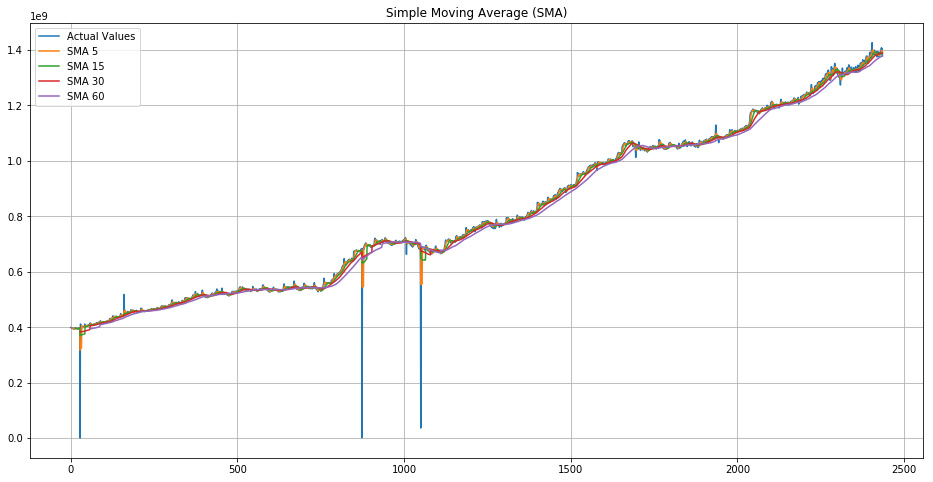

In [23]:
window = 5 #days
df['sma5'] = simple_moving_average(df['value'], window)
window = 15 #days
df['sma15'] = simple_moving_average(df['value'], window)
window = 30 #days
df['sma30'] = simple_moving_average(df['value'], window)
window = 60 #days
df['sma60'] = simple_moving_average(df['value'], window)

plt.figure(figsize=(16,8))
plt.title('Simple Moving Average (SMA)')

plt.plot(df['value'], label='Actual Values')
plt.plot(df['sma5'], label='SMA 5'.format(window))
plt.plot(df['sma15'], label='SMA 15'.format(window))
plt.plot(df['sma30'], label='SMA 30'.format(window))
plt.plot(df['sma60'], label='SMA 60'.format(window))

plt.legend(loc='upper left')
plt.grid(True)
plt.show()